# ch 4. logistic regression 

이번 챕터에서는 torch를 이용해서 classification 모델을 학습시키는 법을 알아보겠습니다. 그 중에서도 가장 단순한 형태의 classification 모델인 logistic regression을 torch로 만들어보면서 개념을 익혀보겠습니다.

## Classfication

Regression 모델은 예측해야 하는 종속 변수가 연속형 변수였습니다. 반면에 Classification은 예측을 해야하는 종속 변수가 범주형 변수입니다. 타이타닉 데이터 셋을 떠올려보면, 승객들의 데이터를 가지고 살았을 지, 죽었을 지 여부를 예측했습니다. 이처럼 데이터를 보고 어떤 종류에 속하는지 분류하는 테스크를 Classification이라고 부르고, 각각의 범주를 Class라고 부릅니다. 

### Sigmoid

logistic regression을 살펴보기에 앞서 먼저 sigmoid 함수에 대해서 알아보겠습니다. 시그모이드 함수는 x에 어떤 값이 들어오든, y 값을 0과 1사이 값으로 출력해주는 함수입니다. (수식을 암기할 필요는 전혀 없습니다.)

$$g(z)=\frac{1}{(1+e^{-z})}$$

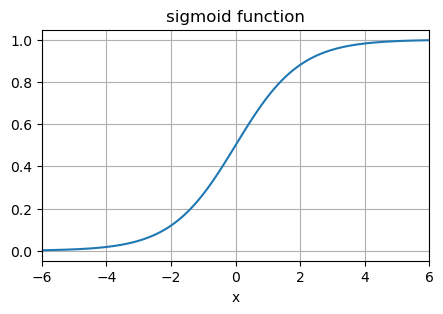

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

x = np.linspace(-6, 6, 121)
y = expit(x)
plt.figure(figsize=(5, 3))
plt.plot(x, y)
plt.grid()
plt.xlim(-6, 6)
plt.xlabel('x')
plt.title('sigmoid function')
plt.show()

### Logistic Regression

먼저 linear regression의 hypothesis를 다시 살펴보겠습니다. 이는 주어진 데이터를 잘 설명할 수 있는 직선의 기울기와 절편을 찾는 모델이었습니다.

$$H(X)=WX+b$$

logistic regression은 종속 변수가 0 혹은 1의 범주형 변수인 binary classification 테스크에 적용할 수 있는 모델입니다. 타이타닉호에서 승객들의 생존 여부를 예측하는 것이 하나의 예입니다. 

그렇다면 linear regression의 결과 값을 sigmoid에 적용하면 어떻게 될까요? linear regression의 결과값이 어떻든, 최종 리턴 값은 0과 1 사이일 것입니다. 그리고 이 값이 0.5보다 작으면 0, 0.5보다 크면 1로 데이터를 분류할 수 있습니다.
$$g(z)=\frac{1}{1+e^{-z}}$$

$$H(X)=\frac{1}{1+e^{-(WX+b)}}$$

### Loss Function

classification 모델을 학습시키기 위해서는 loss function이 달라져야 합니다. 이전에 linear regression은 모델이 예측한 값과 실제 값 사이의 차이의 제곱합을 최소화 시킬 수 있도록 loss function이 설계되었습니다. logistic regression 모델의 hypothesis가 변경된 만큼, loss function도 이에 맞게 변경되어야 합니다.

$$cost(W)=\frac{1}{m}\sum c(H(x), y)$$

$$
\left\{\begin{matrix}
-log(H(x))\;\;\;\;\;\;\;\;\;:y=1\\
-log(1-H(x)) \;\;\;:y=0
\end{matrix}\right.
$$

앞서 logistic regression의 H(x)는 sigmoid 함수에 의해서 0과 1 사이 값을 무조건 갖는다는 걸 알았습니다. loss function을 보면 라벨 y가 1일 때는 -log(H(x)), 라벨이 0일때는 log(H(x))를 취해줍니다. 각각을 그림으로 그려보면 아래와 같습니다.

Text(0, 0.5, 'loss')

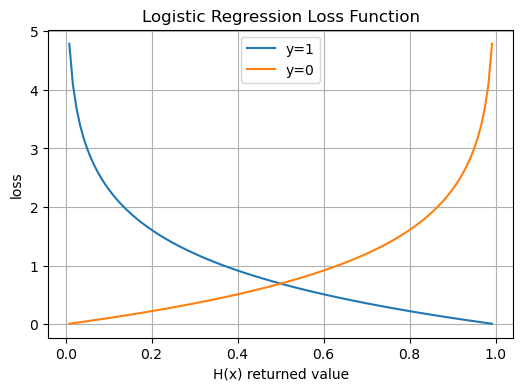

In [3]:
plt.figure(figsize=(6, 4))
x = np.linspace(0, 1, 121)[1:-1]
y0 = -np.log(x)
y1 = -np.log(1 - x)
plt.plot(x, y0, label="y=1")
plt.plot(x, y1, label="y=0")
plt.grid()
plt.legend()
plt.title("Logistic Regression Loss Function")
plt.xlabel("H(x) returned value")
plt.ylabel("loss")

직관적으로 이해해보겠습니다. 예측해야할 라벨 값이 1이라면 모델이 예측한 값이 1에 가까울 수록 loss는 작아져야 합니다. 반대로 라벨 값이 1인데 모델이 예측한 값이 0에 가깝다면 loss가 커져야 합니다. 위 그래프의 파란색 곡선이 바로 이 loss function에 해당합니다. y가 0일 때는 반대로 적용되고, 위 그래프에서 노란색 곡선에 해당합니다.

이제 loss가 최소화가 되도록 모델을 학습시키면 분류를 잘해내는 모델을 얻을 수 있겠죠? y 값에 따라서 나눠서 적는 것이 번거로우니, 수식하나로 이 loss function을 표기해보겠습니다. 

$$c(H(x), y)=ylog(H(x))-(1-y)log(1-H(x))$$

이를 모든 데이터 샘플들에 대해서 계산해서 평균을 취해준 값을 cost function으로 놓고, 이를 편미분한 값으로 weight를 업데이트 해주면 logistic regression 모델을 학습시킬 수 있습니다.

$$cost(W)=\frac{1}{m}\sum ylog(H(x))+(1-y)log(1-H(x))$$

$$W:=W-\alpha\frac{\partial }{\partial W}cost(W)$$

## torch logistic regression

이제 torch로 logistic regression 모델을 만든 뒤, gradient descent 방식으로 학습시켜 보겠습니다. 타이타닉 데이터 셋을 사용하여 지불한 금액이 주어졌을 때, 생존 여부를 예측하는 모델을 만들어 보겠습니다.

### 데이터 셋 준비

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("./data/titanic_train.csv")
df = df[["Survived", "Fare"]]

<Axes: >

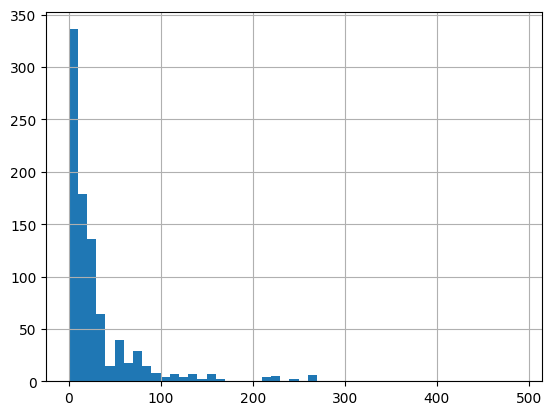

In [9]:
df["Fare"].hist(bins=np.arange(0, 500, 10))

longtail 분포이니 로그를 한번 취해준 뒤, standard scaler 적용

In [5]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
df["Fare"] = np.log1p(df["Fare"])
df["Fare"] = standard_scaler.fit_transform(df[["Fare"]])

In [6]:
X = df["Fare"]
y = df["Survived"]
x_train, x_val, y_train, y_val = train_test_split(X, y,  test_size=0.2, random_state=1234)

In [7]:
import torch

x_train = torch.Tensor(x_train.values).reshape(-1, 1)
y_train = torch.Tensor(y_train.values).reshape(-1, 1)
x_val = torch.Tensor(x_val.values).reshape(-1, 1)
y_val = torch.Tensor(y_val.values).reshape(-1, 1)

### Logistic Regression 모델 작성

In [8]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        out = torch.sigmoid(out)
        return out

### 하이퍼 파라미터 설정

In [11]:
model = LogisticRegression(input_dim=1, output_dim=1)
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = torch.nn.BCELoss() 
epochs = 100

### Train & Validation

train과 validation이 나뉘어 있습니다. train set으로 모델을 학습하고, 10번째 학습마다 validation set으로 성능을 검증해보겠습니다.

In [12]:
from sklearn.metrics import accuracy_score
from collections import defaultdict 

def train(model):
    logs = defaultdict(list)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # inference, calculate loss
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        pred = np.where(outputs> 0.5, 1, 0)
        accuracy = accuracy_score(y_train, pred)
       
        # paramter optimize
        loss.backward()
        optimizer.step()
        
        # validation
        with torch.no_grad():
            val_outputs = model(x_val)
            val_loss = criterion(val_outputs, y_val)
            val_pred = np.where(val_outputs > 0.5, 1, 0)
            val_accuracy = accuracy_score(y_val, val_pred)
        
        logs["train_loss"].append(loss.item())
        logs["train_accuracy"].append(accuracy)
        logs["val_loss"].append(val_loss.item())
        logs["val_accuracy"].append(val_accuracy)

        if (epoch + 1) % 10 == 0:
            print(
                f"epoch: {epoch + 1} train - loss: {round(loss.item(), 4)} acc: {round(accuracy, 4)} " \
                f"val - loss: {round(val_loss.item(), 4)} acc: {round(val_accuracy, 4)}"
            )
    return logs

In [13]:
logs = train(model)

epoch: 10 train - loss: 0.6931 acc: 0.6011 val - loss: 0.6888 acc: 0.6034
epoch: 20 train - loss: 0.6599 acc: 0.6657 val - loss: 0.6631 acc: 0.6425
epoch: 30 train - loss: 0.6396 acc: 0.6854 val - loss: 0.6485 acc: 0.6592
epoch: 40 train - loss: 0.627 acc: 0.6798 val - loss: 0.64 acc: 0.648
epoch: 50 train - loss: 0.6191 acc: 0.6798 val - loss: 0.6352 acc: 0.648
epoch: 60 train - loss: 0.6139 acc: 0.6798 val - loss: 0.6325 acc: 0.6425
epoch: 70 train - loss: 0.6104 acc: 0.6728 val - loss: 0.631 acc: 0.6425
epoch: 80 train - loss: 0.6081 acc: 0.6756 val - loss: 0.6303 acc: 0.6425
epoch: 90 train - loss: 0.6066 acc: 0.6742 val - loss: 0.6301 acc: 0.6425
epoch: 100 train - loss: 0.6055 acc: 0.6742 val - loss: 0.63 acc: 0.6425


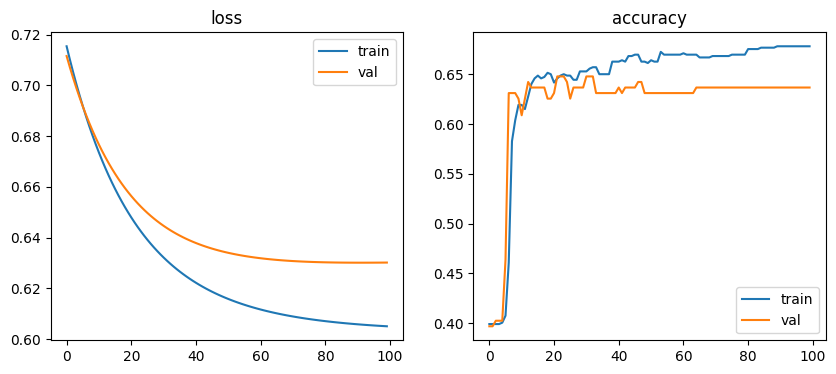

In [63]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10, 4))

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)
ax0.plot(logs["train_loss"], label="train")
ax0.plot(logs["val_loss"], label="val")
ax0.legend()
ax0.set_title("loss")

ax1.plot(logs["train_accuracy"], label="train")
ax1.plot(logs["val_accuracy"], label="val")
ax1.legend()
ax1.set_title("accuracy")
plt.legend()

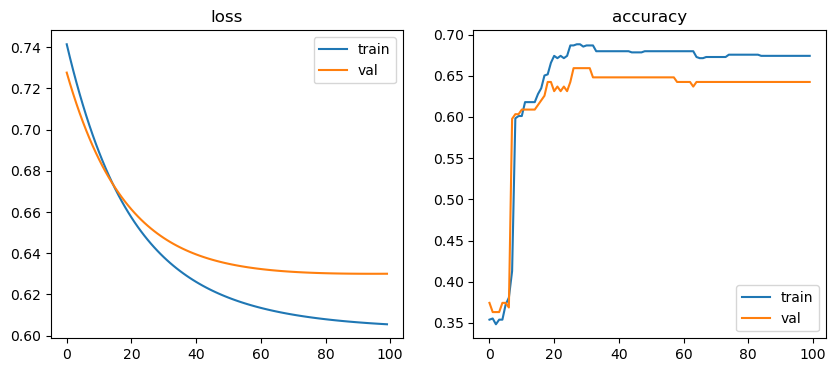

In [14]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10, 4))

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)
ax0.plot(logs["train_loss"], label="train")
ax0.plot(logs["val_loss"], label="val")
ax0.legend()
ax0.set_title("loss")

ax1.plot(logs["train_accuracy"], label="train")
ax1.plot(logs["val_accuracy"], label="val")
ax1.legend()
ax1.set_title("accuracy")
plt.legend()

## 정리

이번 챕터에서는 logistic regression의 개념과 sigmoid 함수를 살펴보았습니다. 그리고 Gradient Descent 방식으로 간단한 logistic regression 모델을 학습시켜보고, loss와 accuracy 변화를 plot으로 그려보았습니다. 다음 챕터에서는 이진 분류를 확장하여 예측해야하는 클래스가 여러개인 상황에서 적용할 수 있는 모델에 대해서 알아보겠습니다.